In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from analysis.heatmap_analysis import generate_heatmap


2023-03-15 16:32:16.362111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:32:16.532568: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 16:32:17.051982: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-03-15 16:32:17.052062: W ten

## Train/Load MDM2 vs. 12ca5 Model



In [ ]:
from functools import partial

protein_of_interest = "MDM2"
other_protein = "12ca5"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
joint_X, joint_y_raw, joint_peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)
(
    (
        mdm2_X_train,
        mdm2_X_test,
        mdm2_y_train,
        mdm2_y_test,
        mdm2_peptides_train,
        mdm2_peptides_test,
    ),
    mdm2_results,
) = experiment.Experiment().run_cross_validation_experiment(
    joint_X,
    joint_y_raw,
    partial(
        rnn.ThreeChannelRegressionRNN_gelu, param_power=7
    ),
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001, weight_decay=0.01
    ),
    load_trained_model=True,
    model_save_name=f"grid_search_models/mdm2_three_channel_longer_model.h5",
    other_datasets=[
        joint_peptides,
    ],
    normalize=True,
)
mdm2_model = mdm2_results.trained_model

In [11]:
protein_of_interest = "12ca5"
other_protein = "MDM2"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
X, y_raw, peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)


/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib[[protein_of_interest + idx for idx in REPLICATE_IDXS]].T,


In [20]:
X.shape

# Remove nans ... aka when p-value = nan (aka when cadherin is the only binder)
nans_mask = ~np.isnan(y_raw).any(axis=1)
# Remove negative infinity ... aka when p-value = 0
neg_inf_mask = ~(y_raw == -np.inf).any(axis=1)
mask = np.logical_and(nans_mask, neg_inf_mask)
good_y_raw = y_raw[mask]


Text(0.5, 1.0, 'Cadherin Datapoints FC by ER')

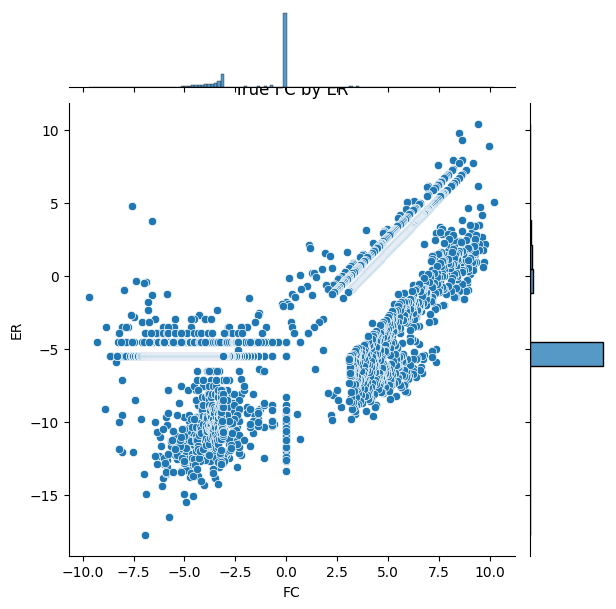

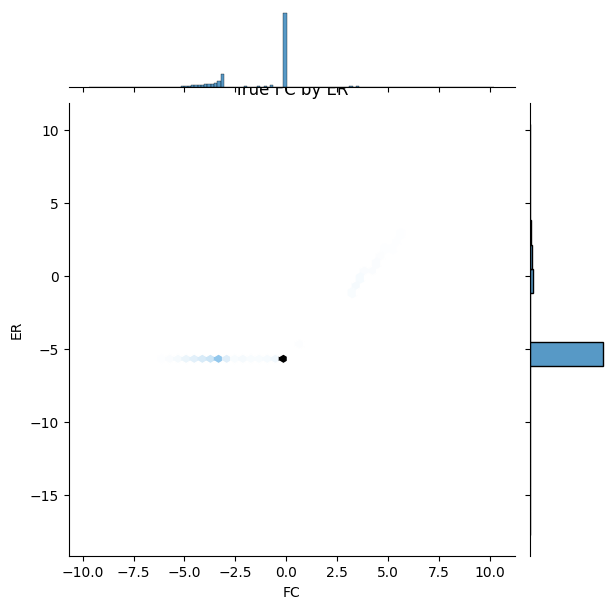

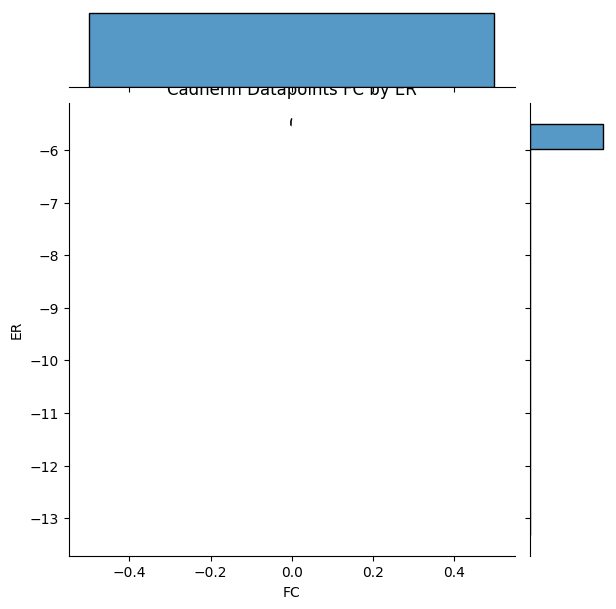

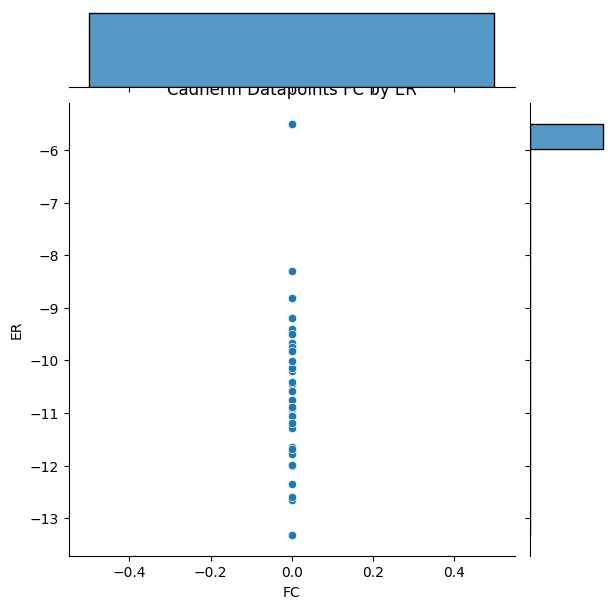

In [19]:
import seaborn as sns
sns.jointplot(x=good_y_raw[:, 1], y=good_y_raw[:, 2])
plt.xlabel('FC')
plt.ylabel('ER')
plt.title('True FC by ER')

sns.jointplot(x=good_y_raw[:, 1], y=good_y_raw[:, 2],kind='hex')
plt.xlabel('FC')
plt.ylabel('ER')
plt.title('True FC by ER')



Text(0.5, 1.0, 'P value predictions')

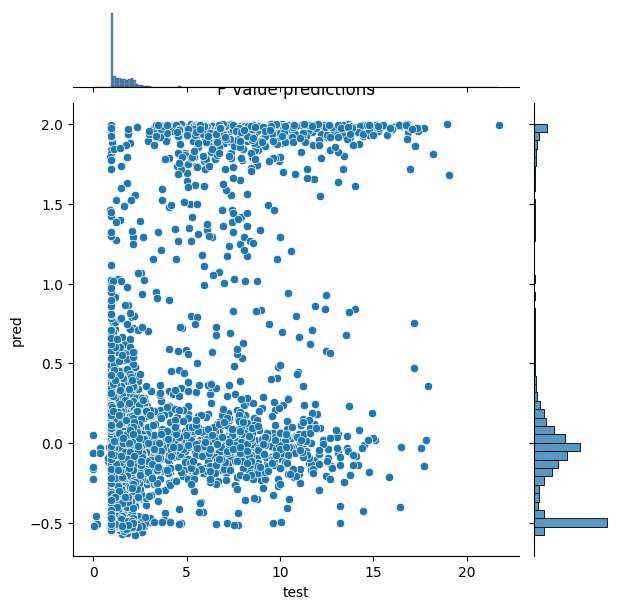

In [76]:
import seaborn as sns
sns.jointplot(x=mdm2_y_test[:, 0], y=mdm2_results.y_pred[:, 0])
plt.xlabel('test')
plt.ylabel('pred')
plt.title('P value predictions')

Text(0.5, 1.0, 'FC predictions')

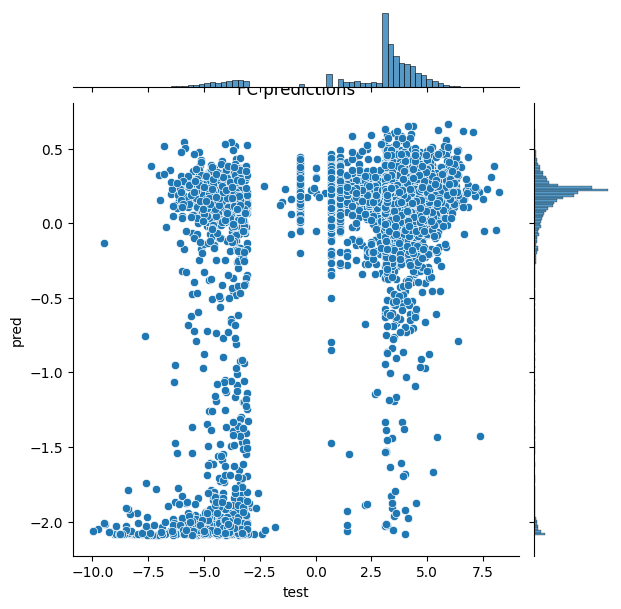

In [77]:
import seaborn as sns
sns.jointplot(x=mdm2_y_test[:, 1], y=mdm2_results.y_pred[:, 1])
plt.xlabel('test')
plt.ylabel('pred')
plt.title('FC predictions')

Text(0.5, 1.0, 'ER predictions')

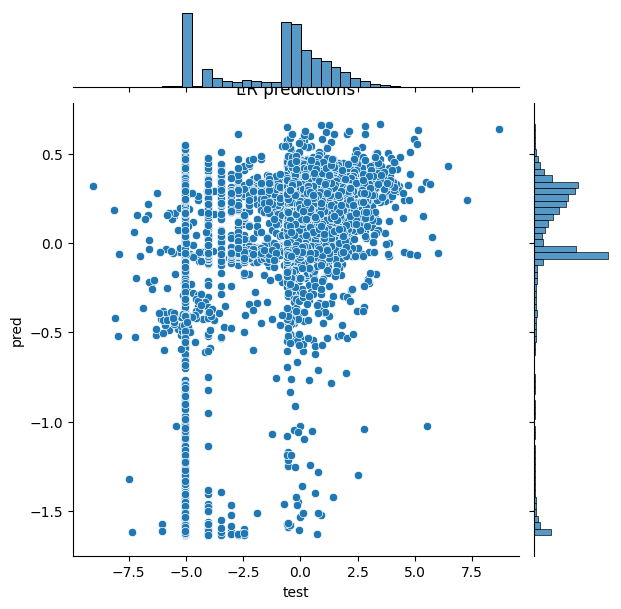

In [78]:
import seaborn as sns
sns.jointplot(x=mdm2_y_test[:, 2], y=mdm2_results.y_pred[:, 2])
plt.xlabel('test')
plt.ylabel('pred')
plt.title('ER predictions')

## Hit Rate by BiLSTM Model Confidence Ranking 

In [80]:
mdm2_results.y_pred[:, 0] * mdm2_results.y_pred[:, 1] * mdm2_results.y_pred[:, 2]

<tf.Tensor: shape=(6583,), dtype=float32, numpy=
array([ 7.2074367e-04,  5.9819683e-03,  7.6693741e-06, ...,
       -3.3387817e-03,  6.5548900e-03,  5.8212486e-04], dtype=float32)>

MDM2 area under curve:  30.494515262110216
normalized MDM2 area under curve:  0.0882193232122524


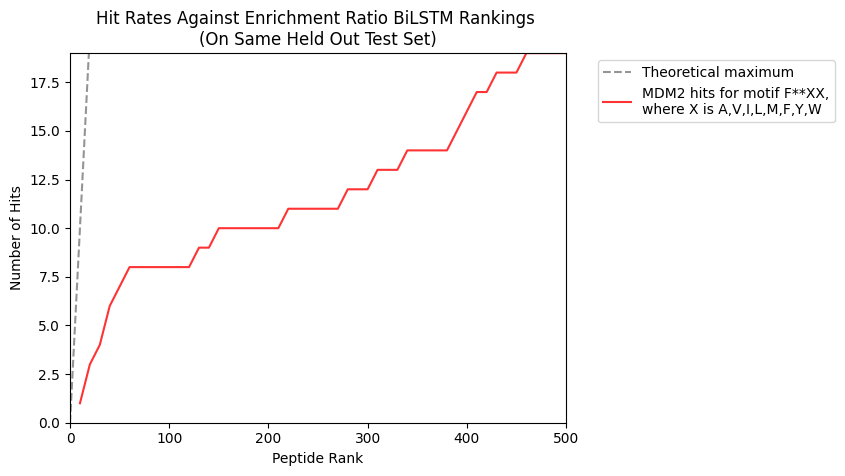

In [5]:
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
)
# ca5_ordering = ca5_y_pred_raw.numpy()
mdm2_ordering = []
for pred in mdm2_results.y_pred:
    if pred[0] > 0 and pred[1] > 0 and pred[2] > 0:
        mdm2_ordering.append(pred[0] * pred[1] * pred[2])
    else:
        mdm2_ordering.append(0)
# mdm2_ordering = [pred[:, 0] * pred[:, 1] * pred[:, 2] if pred[:, 0] * pred[:, 1] * pred[:, 2] for pred in mdm2_results.y_pred] 

plot_ratio_by_ranking(
    peptides=mdm2_peptides_test,
    ca5_y_ranking=None,
    mdm2_y_ranking=mdm2_ordering,
    title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On Same Held Out Test Set)",
    plot_theoretical_maximums=True,
)

# generate_heatmap(
#     sort_peptides_by_model_ranking(mdm2_peptides, mdm2_ordering)[:500],
#     title="Heatmap of top 500 Enrichment Ratio Classification Model Ranked MDM2 Putatitive Binders",
# )
# generate_heatmap(
#     sort_peptides_by_model_ranking(mdm2_peptides, ca5_ordering)[:500],
#     title="Heatmap of top 500 Enrichment Ratio Classification Model Ranked 12ca5 Putatitive Binders",
# )


## Hit Rate by Volcano Plot Ground Truth

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


MDM2 area under curve:  128.30734508661922
normalized MDM2 area under curve:  0.25661469017323846
12ca5 area under curve:  109.41273161356146
normalized 12ca5 area under curve:  0.21882546322712293


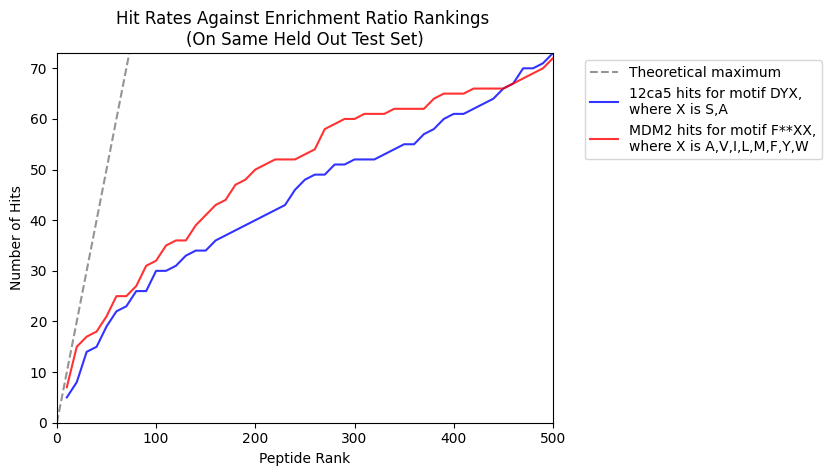

drop C
max is  95.0
drop C
max is  95.0


<AxesSubplot: >

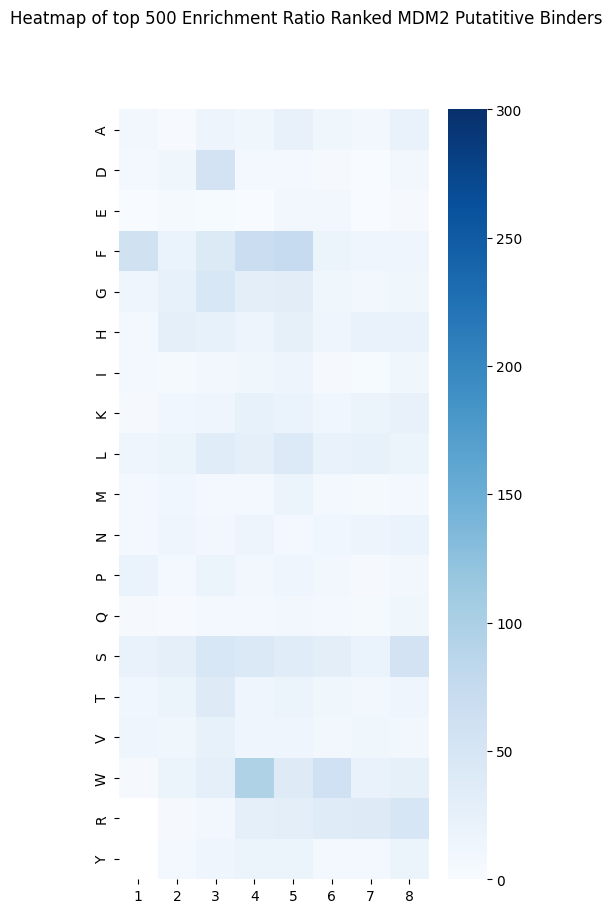

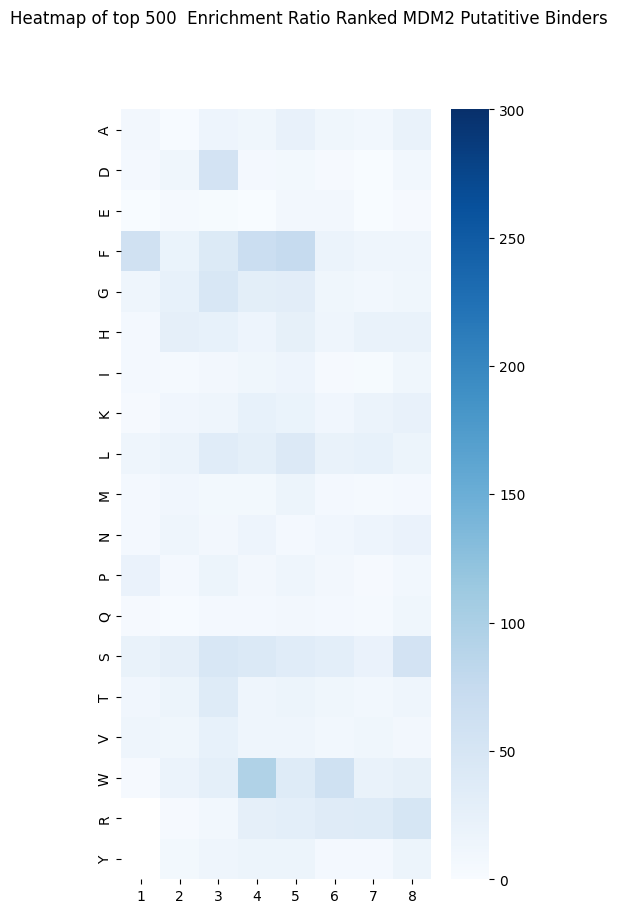

In [43]:
from analysis.hit_rate_analysis import plot_ratio_by_ranking
from analysis.create_weblogos import save_web_logo_alignment

plot_ratio_by_ranking(
    peptides=mdm2_peptides,
    ca5_y_ranking=ca5_y_raw,
    mdm2_y_ranking=mdm2_y_raw,
    title="Hit Rates Against Enrichment Ratio Rankings \n(On Same Held Out Test Set)",
    plot_theoretical_maximums=True,
)

sorted_volcano_mdm2_peptides = sort_peptides_by_model_ranking(mdm2_peptides, mdm2_y_raw)
generate_heatmap(
    sort_peptides_by_model_ranking(mdm2_peptides, mdm2_y_raw)[:500],
    title="Heatmap of top 500 Enrichment Ratio Ranked MDM2 Putatitive Binders",
)
generate_heatmap(
    sort_peptides_by_model_ranking(mdm2_peptides, mdm2_y_raw)[:500],
    title="Heatmap of top 500  Enrichment Ratio Ranked MDM2 Putatitive Binders",
)
